In [168]:
import pandas as pd
import numpy as np
import json
import networkx as nx
import time
import heapq
import subprocess
from subprocess import Popen, PIPE, STDOUT
import time
!chmod +x spike-dasm.exe
!NETWORKX_AUTOMATIC_BACKENDS=cugraph

In [179]:
# Read JSON
with open('hello.out', 'r') as f:
    json_lines = f.readlines()

inst_jsons = []
for line in json_lines:
    try:
        inst_jsons.append(json.loads(line))
    except json.JSONDecodeError:
        pass

In [167]:
p = Popen("./spike-dasm.exe", stdout=PIPE, stdin=PIPE, stderr=PIPE, text=True, shell=True)
stdout_data = p.communicate(input=f"DASM(0x02000033)")[0].strip()
stdout_data

'mul     zero, zero, zero'

0

In [182]:
def generate_data_array(jsons):
    arr = []
    for json in jsons:
        if json["event_name"] == "EX":
            p = Popen("./spike-dasm.exe", stdout=PIPE, stdin=PIPE, stderr=PIPE, text=True, shell=True)
            stdout_data = p.communicate(input=f"DASM({json['data']})")[0].strip()
            arr.append(stdout_data)
        else:
            arr.append(json["data"])
    return np.array(arr)
inst_ids = np.array([inst_jsons[i]["id"] for i in range(len(inst_jsons))])
inst_cycle = np.array([inst_jsons[i]["cycle"].strip() for i in range(len(inst_jsons))])
inst_event = np.array([inst_jsons[i]["event_name"] for i in range(len(inst_jsons))])
data_field = generate_data_array(inst_jsons)
inst_parent = np.array([inst_jsons[i]["parents"] for i in range(len(inst_jsons))])
data = np.column_stack((inst_ids,inst_parent, inst_cycle, inst_event, data_field))
columns = ["inst_id", "parent_id", "cycle", "stage", "data"]
df = pd.DataFrame(data=data, columns=columns)

In [184]:
df[df["stage"] == "EX"]

,inst_id,parent_id,cycle,stage,data
26,0x0000000400000010,0x000000010000000f,16,EX,"auipc a0, 0x0"
29,0x0000000400000011,0x0000000100000010,17,EX,"addi a0, a0, -64"
33,0x0000000400000012,0x0000000100000011,18,EX,"csrw mtvec, a0"
38,0x0000000400000013,0x0000000100000012,19,EX,"csrr t0, misa"
54,0x0000000400000017,0x0000000100000016,23,EX,"csrr t0, misa"
...,...,...,...,...,...
203945,0x0000000400025851,0x000000010002584d,153681,EX,"auipc a3, 0x0"
203951,0x0000000400025852,0x000000010002584e,153682,EX,"sd zero, 1084(a3)"
203956,0x0000000400025853,0x000000010002584f,153683,EX,"sd a5, 0(a4)"
203962,0x0000000400025854,0x0000000200025853,153684,EX,j pc - 0xa


In [185]:
def construct_graph(df):
    DG = nx.DiGraph()
    for row in df.itertuples():
        DG.add_node(row.inst_id, cycle=row.cycle, data=row.data, stage=row.stage)
        if row.parent_id != "None":
            DG.add_edge(row.parent_id, row.inst_id)
    return DG

def construct_speculative_trace(G):
    paths = []
    id = 0
    for node in G:
        data = G.nodes[node]
        if G.in_degree(node) == 0: # root node
            new_paths = trace_down(G, node, [], [])
            paths.extend(new_paths)
    for path in paths:
        if path[-1][0] != "RET":
            path.append(("FLUSH", str(int(path[-1][1]) + 1), None))
        path.insert(0, (id, path[0][-1]))
    return paths

def trace_down(G, node, curr_path, paths):
    data = G.nodes[node]
    curr_path.append((data["stage"], data["cycle"], data["data"]))
    if G.out_degree(node) == 0: # terminal node
        paths.append(curr_path)
        return paths
    succs = DG.successors(node)
    for n in succs:
        paths.extend(trace_down(G, n, curr_path[:], []))
    return paths

def construct_committed_trace(G):
    paths = []
    id = 0
    for node in G:
        data = G.nodes[node]
        if G.out_degree(node) == 0 and data["stage"] == "RET": # committed leaf node
            new_path = trace_up(G, node)
            new_path.insert(0, (id, data["data"]))
            paths.append(new_path)
            id += 1
    return paths

def trace_up(G, node):
    path = []
    while node:
        data = G.nodes[node]
        path.insert(0, (data["stage"], data["cycle"], data["data"]))
        node = list(DG.predecessors(node))[0] if list(DG.predecessors(node)) else ""
    return path
    

In [186]:
DG = construct_graph(df)

In [115]:
num_paths = 0
for node in DG:
    if DG.out_degree(node) == 0: # leaf node
        num_paths += 1
num_paths

156650

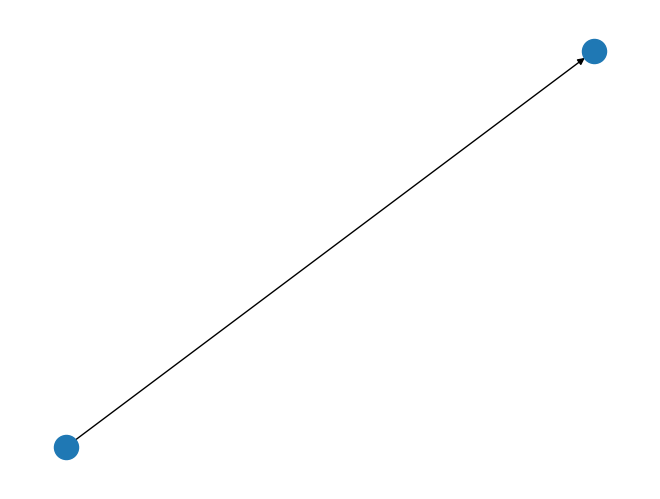

In [19]:
for node in DG:
    data = DG.nodes[node]
    if DG.in_degree(node) == 0: # committed leaf node
        nx.draw(DG.subgraph([node] + list(nx.descendants(DG, node))))
        break

In [7]:
paths = construct_committed_trace(DG)

In [187]:
spec_paths = construct_speculative_trace(DG)

[(0, '0x0000010040'), ('IF1', '14', '0x0000010040'), ('IF2', '15', '0x0000010040'), ('EX', '16', '0x0000010040'), ('MEM', '17', '0x0000010040'), ('WB', '18', '0x0000010040'), ('RET', '19', 'auipc   a0, 0x0')]
[(0, '0x0000010044'), ('IF1', '15', '0x0000010044'), ('IF2', '16', '0x0000010044'), ('EX', '17', '0x0000010044'), ('MEM', '18', '0x0000010044'), ('WB', '19', '0x0000010044'), ('RET', '20', 'addi    a0, a0, -64')]
[(0, '0x0000010048'), ('IF1', '16', '0x0000010048'), ('IF2', '17', '0x0000010048'), ('EX', '18', '0x0000010048'), ('MEM', '19', '0x0000010048'), ('WB', '20', '0x0000010048'), ('RET', '21', 'csrw    mtvec, a0')]
[(0, '0x000001004c'), ('IF1', '21', '0x000001004c'), ('IF2', '22', '0x000001004c'), ('EX', '23', '0x000001004c'), ('MEM', '24', '0x000001004c'), ('WB', '25', '0x000001004c'), ('RET', '26', 'csrr    t0, misa')]
[(0, '0x0000010050'), ('IF1', '22', '0x0000010050'), ('IF2', '23', '0x0000010050'), ('EX', '26', '0x0000010050'), ('MEM', '27', '0x0000010050'), ('WB', '28',

In [191]:
import heapq

def convert_to_kanata(threads, verbose=False):
    pq = []
    id = 0
    if not verbose:
        threads = list(filter(lambda x: x[-1][0] == 'RET', threads)) #Relies on the last element of inst list being RET
    for inst in threads:
        for stage in inst[1:]:
            heapq.heappush(pq, ((int(stage[1])), (id, stage[2], stage[0]))) #Min heap of (cycle -> (unique_id, pc, pipeline stage))
        id += 1
            
    with open('hello2.log', 'w') as file:
        file.write('Kanata    0004\n')
        cycle, (id, pc, stage) = heapq.heappop(pq)
        prev_cycle = cycle
        file.write(f'C=\t{cycle}\n')
        while pq:
            cycle_diff = cycle - prev_cycle
            if (cycle_diff > 0):
                file.write(f"C\t{cycle_diff}\n")
            if (stage == 'IF1'):
                file.write(f"I\t{id}\t{cycle}\t0\n")
                # file.write(f"L    {id}    0    {pc}\n")
            if (stage == 'RET'):
                file.write(f"R\t{id}\t{id}\t0\n")
            elif (stage == 'FLUSH'):
                file.write(f"R\t{id}\t{id}\t1\n")
            elif (stage == "EX"):
                file.write(f"S\t{id}\t0\t{stage}\n")
                file.write(f"L\t{id}\t0\t{pc} \n")
            else:
                file.write(f"S\t{id}\t0\t{stage}\n")
                file.write(f"L\t{id}\t1\tPC:{pc}\n")

            prev_cycle = cycle
            cycle, (id, pc, stage) = heapq.heappop(pq)

In [192]:
convert_to_kanata(spec_paths, verbose=True)